# Enzyme Project
## Plots from Xixi's files

Here we try to produce nice plots from the experimental data. The idea is to take the data from the microfluidic device, fit it to a model, then estimate a confidence interval. Then we can run a significance test for the migration towards each side.

In [2]:
library(dplyr)
library(ggplot2)
library(cowplot)
library(magrittr)
library(tidyr)
library(broom)
library(splines)
library(scales)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



### Figure 2 data

In [3]:
fig2 <- read.csv("../rawdata/fig2.csv")

In [4]:
normal.vector <- colSums(fig2)/sum(fig2$Buffer)

Normalizing all data to a sum equal to sum of buffer normalized fliuorescence intensities

In [5]:
normal.vector[1] = 1

In [6]:
fig2 <- mapply("/",fig2,normal.vector)

In [7]:
fig2 <- as.data.frame(fig2)


In [8]:
# Putting data in tidy format
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)


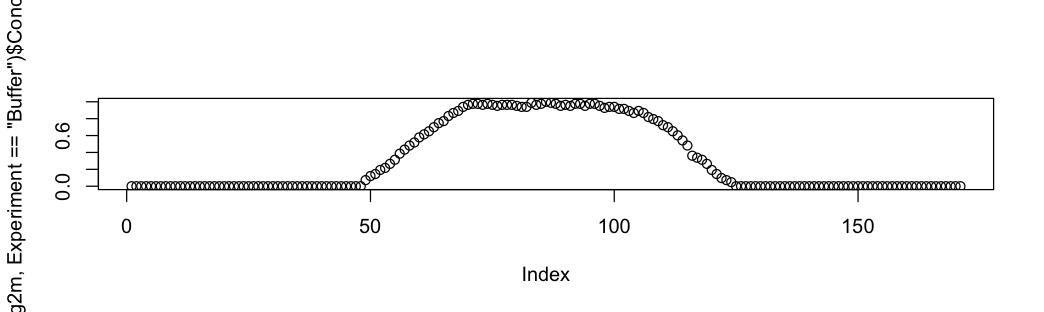

In [9]:
plot(filter(fig2m,Experiment == 'Buffer')$Concentration)

Next we specify the model. The solution for our initial conditions is $a * erf(\frac{x-c}{\sqrt{4Dt}}) +b$, where $c$ is the step point at $t=0$, and $a$ and $b$ are determined by inital concentrations. As the geometry is also subject to noise, we add two offset parameters for the inital concentration profile (the locations of the channel limits).

We then fit the model using the `nls` R package. We also use the confidence intervals given by the package to fit the upper and lower bounds of the model.

In [10]:
erf <- function(x) 2*pnorm(x*sqrt(2)) -1
# fig2mgroup <- fig2m %>% group_by(variable)
# models <- list()
m <- function(df) {
    mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = df)
    pred <- fitted(mod)
    data.frame(df,pred)
    params = confint(mod, level= 0.95)
    cc <- coef(mod)
    l <- params[,1]
    u <- params[,2]
    lwr <- l[1]*(erf((df$Distance+l[2]-100)/sqrt(4*l[3])) - erf((df$Distance+u[4]-220)/sqrt(4*l[5])))
    upr <- u[1]*(erf((df$Distance+u[2]-100)/sqrt(4*u[3])) - erf((df$Distance+l[4]-220)/sqrt(4*u[5])))
    data.frame(df,pred,lwr,upr,cc[2],cc[4])
}
result <- fig2m %>% group_by(Experiment) %>% do(m(.))
models <- fig2m %>% group_by(Experiment) %>% do(model = nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = .))
library(plyr)
result <- rename(result,c("cc.2."="offsetleft","cc.4."="offsetright"))
glimpse(result)


Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...
Warning message:
In data.frame(df, pred, lwr, upr, cc[2], cc[4]): row names were found from a short variable and have been discardedWarning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initia

Observations: 684
Variables: 8
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.345031e-17, 1.603509e-16, 4.810528e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.310999e-1...
$ upr           (dbl) 1.613805e-16, 5.379350e-16, 1.667599e-15, 5.217970e-1...
$ offsetleft    (dbl) -8.261142, -8.261142, -8.261142, -8.261142, -8.261142...
$ offsetright   (dbl) 5.438476, 5.438476, 5.438476, 5.438476, 5.438476, 5.4...


In [11]:
mod <- nls(Concentration ~ alph*(erf((Distance+offset1-100)/sqrt(4*Dt1)) - erf((Distance+offset2-220)/sqrt(4*Dt2))), data = subset(result,Experiment=='Buffer'))
confint(mod, level= 0.95)
summary(mod)

Warning message:
In nls(Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * : No starting values specified for some parameters.
Initializing ‘alph’, ‘offset1’, ‘Dt1’, ‘offset2’, ‘Dt2’ to '1.'.
Consider specifying 'start' or using a selfStart modelWaiting for profiling to be done...


,2.5%,97.5%
alph,0.4783722,0.4845288
offset1,-8.612695,-7.909950
Dt1,76.09415,87.48447
offset2,5.092666,5.785783
Dt2,68.63914,80.25624



Formula: Concentration ~ alph * (erf((Distance + offset1 - 100)/sqrt(4 * 
    Dt1)) - erf((Distance + offset2 - 220)/sqrt(4 * Dt2)))

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
alph     0.481438   0.001547  311.25   <2e-16 ***
offset1 -8.261142   0.177426  -46.56   <2e-16 ***
Dt1     81.631500   3.106581   26.28   <2e-16 ***
offset2  5.438476   0.172612   31.51   <2e-16 ***
Dt2     74.274304   2.886510   25.73   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01684 on 166 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 5.17e-06


In [12]:
#adding channel data
result$channel <- 0
result$channel[result$Distance <= 100] <- 'left'
result$channel[result$Distance > 100 & result$Distance <= 220] <- 'center'
result$channel[result$Distance > 220] <- 'right'
glimpse(result)

Observations: 684
Variables: 9
$ Distance      (dbl) 0.0000, 1.8895, 3.7791, 5.6686, 7.5581, 9.4477, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ pred          (dbl) 0.000000e+00, 5.345031e-17, 1.603509e-16, 4.810528e-1...
$ lwr           (dbl) 0.000000e+00, 0.000000e+00, 0.000000e+00, 5.310999e-1...
$ upr           (dbl) 1.613805e-16, 5.379350e-16, 1.667599e-15, 5.217970e-1...
$ offsetleft    (dbl) -8.261142, -8.261142, -8.261142, -8.261142, -8.261142...
$ offsetright   (dbl) 5.438476, 5.438476, 5.438476, 5.438476, 5.438476, 5.4...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [13]:
detach("package:plyr", unload=TRUE)

Warning message:
: ‘plyr’ namespace cannot be unloaded:
  namespace ‘plyr’ is imported by ‘scales’, ‘ggplot2’, ‘reshape2’, ‘broom’ so cannot be unloaded

In [14]:
groupy <- group_by(result,channel,Experiment)
summed <- summarise(groupy, pred = sum(pred), lwr = sum(lwr), upr = sum(upr), actual = sum(Concentration))
names(summed)[2] = 'experiment'
summed <- gather(summed, "variable","value", c(pred,actual))
summed$upr[summed$variable == 'actual'] <- NaN
summed$lwr[summed$variable == 'actual'] <- NaN

Warning message:
: Removed 8 rows containing missing values (geom_errorbar).

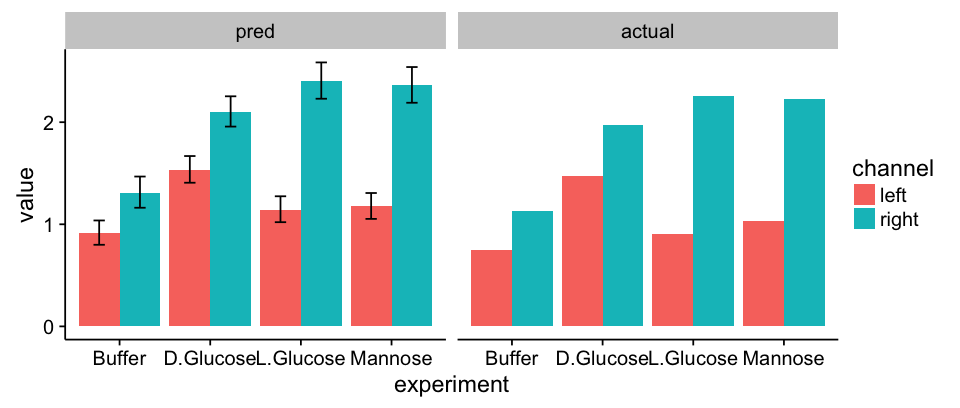

In [15]:
options(repr.plot.width = 8, repr.plot.height = 3.4)

a <- ggplot(data = subset(summed, channel != 'center'),aes(x=experiment, y=value, group = channel))
a <- a+geom_bar(stat='identity',position = "dodge", aes(fill = channel))
a <- a+geom_errorbar(aes(ymin = lwr, ymax =upr),position=position_dodge(width = 0.9),width = .25)
a + facet_grid(. ~ variable)

In [16]:
control.conc = filter(result, Experiment == 'Buffer')$Concentration
control.pred = filter(result, Experiment == 'Buffer')$pred
result %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()
result %<>% rename(Substrate = Experiment)

In [17]:
summed %<>% rename(Substrate = experiment)
control.conc <- filter(summed, Substrate == 'Buffer')$value
control.lwr <- filter(summed, Substrate == 'Buffer')$lwr
control.upr <- filter(summed, Substrate == 'Buffer')$upr
summed %<>% group_by(Substrate) %>% mutate(control.concentration = control.conc,control.lwr = control.lwr,
                                           control.upr = control.upr)
summed %<>% ungroup()


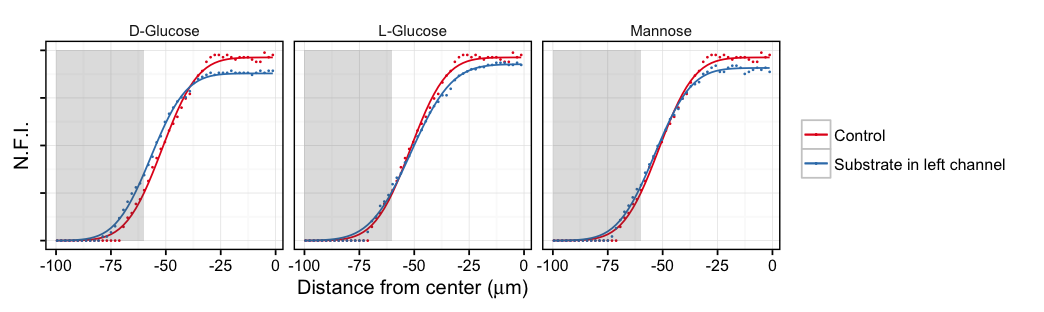

In [18]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = -100
xmax = 0

raw <- ggplot(data = filter(result,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_line(aes(y = control.pred,color = cols[2])) +
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_point(size = 0.1) +
    geom_line(aes(y = pred)) +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in left channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = xmin, xmax = -60, ymin = 0.000025, ymax = +1.00091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

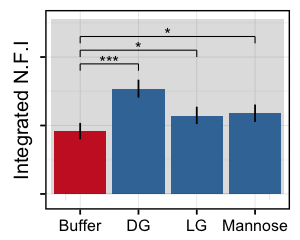

In [19]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated <- ggplot(data = filter(summed, channel == 'left', variable == 'pred') , 
                     aes(x=Substrate, y= value)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
    annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lwr,ymax = upr ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = c(1.9, 2.1, 2.3, 0.0037),
                      ann.yend = c(1.9,2.1,2.3,0.0037), 
                       ann.text = c("***","*","*",""),
                       ann.ytextoffset = c (0.04,0.04,0.04,0.04),
                       ann.xtextoffset = c (.5,0,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(0,0,0,0)

prongsize1 = 0.1
textoff = 0.3

integrated <- integrated + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated)

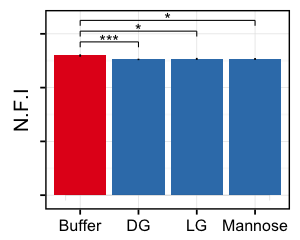

In [20]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated2 <- ggplot(data = filter(summed, channel == 'center', variable == 'pred') , 
                     aes(x=Substrate, y= value)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lwr,ymax = upr ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = c(57, 61, 65, 0.0037),
                      ann.yend = c(57,61,65,0.0037), 
                       ann.text = c("***","*","*",""),
                       ann.ytextoffset = c (0.5,0.5,0.5,0.5),
                       ann.xtextoffset = c (.5,0,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(0,0,0,0)

prongsize = 2
textoff = 1

integrated2 <- integrated2 + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated2)

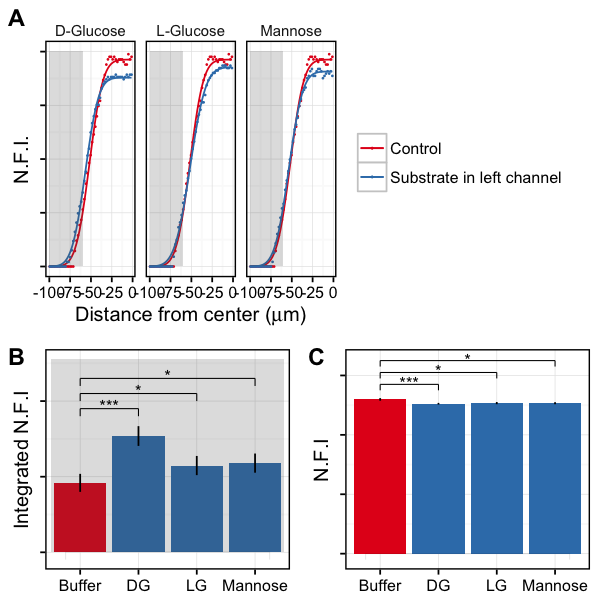

In [21]:
options(repr.plot.width = 5, repr.plot.height = 5)

line2 = plot_grid(integrated,integrated2, labels = c("B","C"),ncol = 2)

plot_grid(raw,line2, labels = c("A",""),ncol = 1,rel_heights = c(1.3,1))

### New version following A. Sen comments.

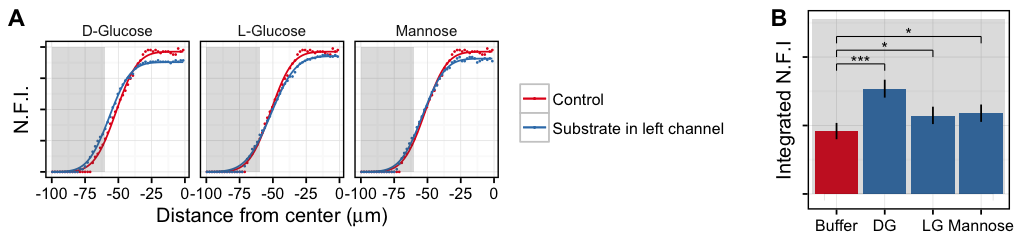

In [22]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1))

In [23]:
ggsave("./img/RoleOfCatalysisPlot.png",width = 8.5, height = 2)

ERROR: Error in grDevices::dev.off(): QuartzBitmap_Output - unable to open file './img/RoleOfCatalysisPlot.png'


In [24]:
# test between Buffer and DG
DG1 <- filter(summed, channel == 'center', variable == 'L.Glucose')$totalconc
DG1_lw <- filter(summed, channel == 'center', variable == 'L.Glucose')$lwr
DG_se <- DG1-DG1_lw
Buff1 <- filter(summed, channel == 'center', variable == 'Buffer')$totalconc
Buff1_lw <- filter(summed, channel == 'center', variable == 'Buffer')$lwr
Buff_se <- Buff1-Buff1_lw

In [25]:
ttest1 <- (-DG1 + Buff1)/sqrt(Buff_se/1.96 + DG_se/1.96)
ttest1

ERROR: Error in -DG1: invalid argument to unary operator


ERROR: Error in eval(expr, envir, enclos): object 'ttest1' not found


*Next steps*: 
- run ANOVA
- run games howell test to identify the differences
- plot the histograms with the p-values
- maybe do the qqplot of the fit?

In [26]:

anova(models$model[[1]],models$model[[2]],models$model[[3]],models$model[[4]])

,Res.Df,Res.Sum Sq,Df,Sum Sq,F value,Pr(>F)
1,166,0.04708758,NA,NA,NA,NA
2,166,0.02984191,0,0,NA,NA
3,166,0.03718797,0,0,NA,NA
4,166,0.03698036,0,0,NA,NA


In [27]:
control.conc = filter(result, Experiment == 'Buffer')$Concentration
control.pred = filter(result, Experiment == 'Buffer')$pred
result %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc,control.pred = control.pred)
result %<>% ungroup()
result %<>% rename(Substrate = Experiment)

ERROR: Error in eval(expr, envir, enclos): object 'Experiment' not found


ERROR: Error in eval(expr, envir, enclos): object 'Experiment' not found


ERROR: Error in eval(expr, envir, enclos): unknown column 'Experiment'


ERROR: Error: Unknown variables: Experiment.


## Plot with longer channels

In [28]:
fig2 <- read.csv("../rawdata/fig5mean.csv")

In [29]:
normal.vector <- colSums(fig2)/sum(fig2$Buffer)

In [30]:
normal.vector[1] = 1

In [31]:
fig2 <- mapply("/",fig2,normal.vector)

In [32]:
colSums(fig2)

Distance      Buffer   D.Glucose   L.Glucose     Mannose 
27770.62110    49.81197    49.81197    49.81197    49.81197

In [33]:
fig2 <- as.data.frame(fig2)


In [34]:
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)


In [35]:
#adding channel data
fig2m$channel <- 0
fig2m$channel[fig2m$Distance <= 100] <- 'left'
fig2m$channel[fig2m$Distance > 100 & fig2m$Distance <= 220] <- 'center'
fig2m$channel[fig2m$Distance > 220] <- 'right'
glimpse(fig2m)

Observations: 688
Variables: 4
$ Distance      (dbl) 0.0000, 1.8884, 3.7768, 5.6652, 7.5535, 9.4419, 11.33...
$ Experiment    (fctr) Buffer, Buffer, Buffer, Buffer, Buffer, Buffer, Buff...
$ Concentration (dbl) 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
$ channel       (chr) "left", "left", "left", "left", "left", "left", "left...


In [36]:
control.conc = filter(fig2m, Experiment == 'Buffer')$Concentration
fig2m %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc)
fig2m %<>% ungroup()
fig2m %<>% rename(Substrate = Experiment)

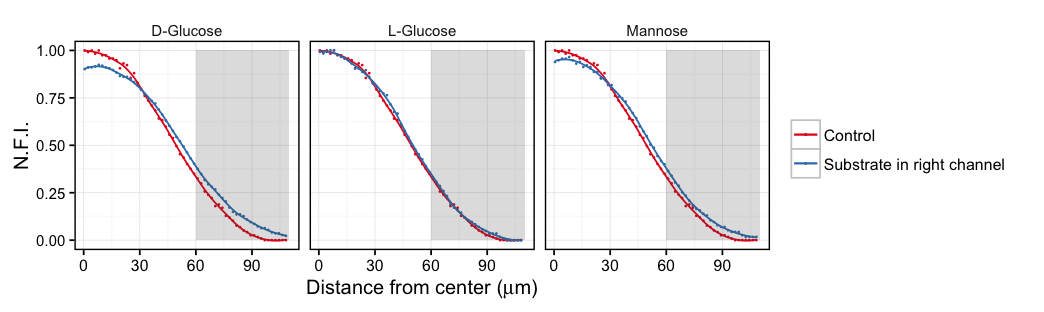

In [37]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(fig2m,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_smooth(aes(y = control.concentration,color = cols[2]),method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    geom_point(size = 0.1) +
    geom_smooth(method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in right channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=9),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

### Redo of figure 5

In [38]:
fig2 <- read.csv("../rawdata/fig5.csv")

In [39]:
head(fig2)

,Distance,Buffer,D.Glucose,L.Glucose,Mannose,Replicate
1,0,2,1,3,2,A
2,1.8884,2,1,3,2,A
3,3.7768,2,1,3,2,A
4,5.6652,2,1,3,2,A
5,7.5535,2,1,3,2,A
6,9.4419,2,1,3,2,A


In [40]:
fig2m <- gather(fig2,"Experiment","Concentration",Buffer:Mannose)

In [41]:
head(fig2m)

,Distance,Replicate,Experiment,Concentration
1,0,A,Buffer,2
2,1.8884,A,Buffer,2
3,3.7768,A,Buffer,2
4,5.6652,A,Buffer,2
5,7.5535,A,Buffer,2
6,9.4419,A,Buffer,2


In [42]:
 normalit<-function(m){
   (m - min(m))/(max(m)-min(m))
 }

In [43]:
fig2m %<>% group_by(Replicate,Experiment) %>% mutate(Concentration = normalit(Concentration))

In [44]:
control.conc = filter(fig2m, Experiment == 'Buffer')$Concentration
fig2m %<>% group_by(Experiment) %>% mutate(control.concentration = control.conc)
fig2m %<>% ungroup()
fig2m %<>% rename(Substrate = Experiment)

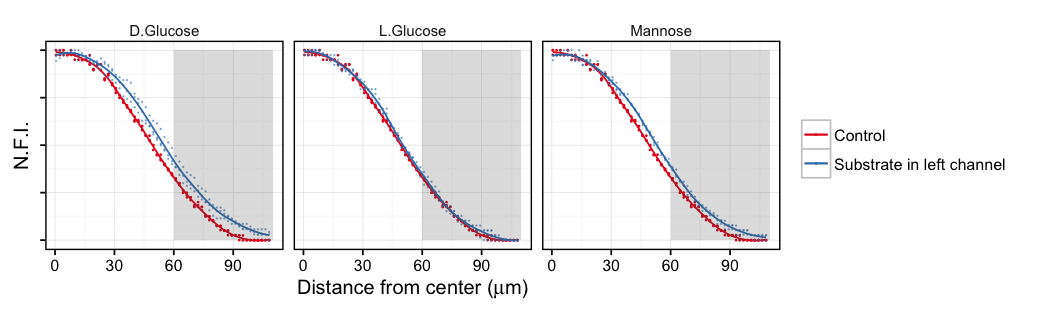

In [45]:
options(repr.plot.width = 8.7, repr.plot.height = 2.6)
cols <- hue_pal()(2)

xmin = 0
xmax = 110

raw <- ggplot(data = filter(fig2m,Substrate != "Buffer",Distance-160>=xmin,Distance-160 <=xmax),aes(x = Distance-160,y = Concentration,color = cols[1])) + 
    geom_point(size = 0.1,aes(y = control.concentration,color = cols[2])) +
    geom_smooth(aes(y = control.concentration,color = cols[2]),method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    geom_point(size = 0.001,alpha = 0.5) +
    geom_smooth(method = 'loess', se =FALSE, size = 0.5,span=.3)  +
    ylab("N.F.I.") +
    xlab(expression(paste("Distance from center (", mu, "m)", sep = ""))) +
    scale_color_brewer(palette='Set1',labels = c("Control","Substrate in left channel")) +
    facet_grid(. ~ Substrate,
               labeller = labeller(Experiment =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose'))) +
    theme_bw() +     
    theme(panel.border = element_rect(size = 0.8, colour = "black"),
        axis.text.y = element_text(size=0),
        legend.title=element_blank(),
         strip.text = element_text(size = 9, vjust = -150),
         strip.background = element_rect(fill = NA, size = NA)) +
#          legend.position='bottom') +
    annotate("rect", xmin = 60, xmax = xmax, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     annotate("rect", xmin = 60, xmax = 160, ymin = 0.000025, ymax = +1.000091, alpha = .2)
#     scale_x_continuous(limits = c(-120, -20))

    
print(raw)

In [46]:
m <- function(df,m) {
    temp <- df %>%
        bootstrap(m) %>%
#          do(augment(glm(data = ., Concentration ~ ns(Distance, df = 6)),.))
         do(augment(loess(data = ., Concentration ~ Distance, span =0.6),.))
    temp
}

In [47]:
fig2m %<>% filter(Distance >160, Distance <270)

In [48]:

bs <- fig2m %>%
    group_by(Replicate, Substrate) %>%
    do(m(.,50))

In [49]:
bs$channel <- 0
bs$channel[bs$Distance > 100 & bs$Distance <= 220] <- 'center'
bs$channel[bs$Distance > 220] <- 'right'
bs$channel <- factor(bs$channel, levels = c ('center','right'))

In [50]:
bs %<>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    mutate(concentration.channel.integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bs %<>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    mutate(.fitted.channel.integral = t(diff(Distance)) %*% .fitted[1:(length(.fitted)-1)])
bs %<>% ungroup() %>% group_by(replicate,Replicate,Substrate) %>% 
    mutate(concentration.integral = sum(concentration.channel.integral))
bs %<>% ungroup() %>% group_by(replicate,Replicate,Substrate) %>% 
    mutate(.fitted.integral = sum(.fitted.channel.integral))
# focusing_bs %<>% ungroup() %>% group_by(Experiment,replicate,channel,Substrate) %>% 
#     mutate(concentration.normalized = sum(Integral)/mean(normalized))
bs$concentration.normalized <- bs$Concentration / bs$concentration.integral
bs$.fitted.normalized <- as.vector(bs$.fitted) / as.vector(bs$.fitted.integral)
bs$.fitted.normalized.channel.integral <- as.vector(bs$.fitted.channel.integral) / as.vector(bs$.fitted.integral )
glimpse(bs)

Observations: 34,800
Variables: 17
$ replicate                           (int) 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ Distance                            (dbl) 160.5129, 164.2897, 166.1781, 1...
$ Replicate                           (fctr) A, A, A, A, A, A, A, A, A, A, ...
$ Substrate                           (fctr) Buffer, Buffer, Buffer, Buffer...
$ Concentration                       (dbl) 1.0000000, 1.0000000, 0.9736842...
$ control.concentration               (dbl) 1.0000000, 1.0000000, 0.9736842...
$ .fitted                             (dbl) 0.9878008, 0.9909068, 0.9895484...
$ .se.fit                             (dbl) 0.006032178, 0.004134440, 0.003...
$ .resid                              (dbl) 1.219919e-02, 9.093184e-03, -1....
$ channel                             (fctr) center, center, center, center...
$ concentration.channel.integral      (dbl) 44.72496, 44.72496, 44.72496, 4...
$ .fitted.channel.integral            (dbl) 44.5847, 44.5847, 44.5847, 44.5...
$ concentration.i

In [51]:
alpha <- 0.05
bs_recap <- bs %>%
    group_by(Substrate, Distance,channel) %>% 
    summarise(lo = quantile(.fitted.normalized,alpha/2), 
              hi = quantile(.fitted.normalized,1-alpha/2), 
              smooth = mean(.fitted.normalized), 
              orig = mean(concentration.normalized))
bs %<>% group_by(Substrate, Distance,channel) %>% 
    mutate(lo = quantile(.fitted.normalized,alpha/2), hi = quantile(.fitted.normalized,1-alpha/2))

In [52]:
head(bs_recap)

,Substrate,Distance,channel,lo,hi,smooth,orig
1,Buffer,160.5129,center,0.0005327621,0.0008197422,0.0006415758,0.0006406323
2,Buffer,162.4013,center,0.0005338464,0.0008615642,0.000650899,0.0006465158
3,Buffer,164.2897,center,0.000536811,0.0008004377,0.0006537759,0.0006536645
4,Buffer,166.1781,center,0.0005526264,0.0008225503,0.0006477617,0.0006408297
5,Buffer,168.0665,center,0.0005261578,0.0007902775,0.0006417849,0.0006474551
6,Buffer,169.9548,center,0.0005261851,0.0007682374,0.0006285746,0.0006244382


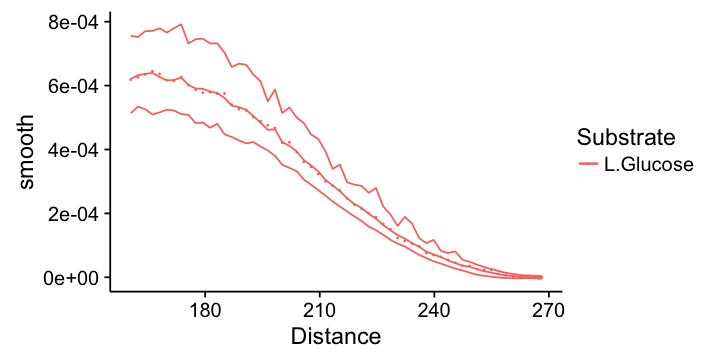

In [53]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(data=filter(bs_recap,Substrate =="L.Glucose"),aes(x=Distance,color=Substrate)) + geom_line(aes(y=smooth)) +
    geom_line(aes(y=lo)) + geom_line(aes(y=hi)) + geom_point(aes(y=orig),size=0.1)


In [54]:
bychannel_bs <- bs %>% group_by(replicate,Replicate,Substrate,channel) %>% arrange(Distance) %>%
    summarise(Integral = t(diff(Distance)) %*% Concentration[1:(length(Concentration)-1)])
bychannel_bs %<>% ungroup() %>% group_by(Substrate,replicate,Replicate) %>% mutate(normalized = sum(Integral))
bychannel_bs %<>% ungroup() %>% group_by(Replicate,replicate,channel,Substrate) %>% mutate(concentration = sum(Integral)/mean(normalized))
check <- bychannel_bs %>% ungroup() %>% group_by(Substrate,Replicate,replicate) %>% summarise(sum = sum(concentration))
head(check)

,Substrate,Replicate,replicate,sum
1,Buffer,A,1,1
2,Buffer,A,2,1
3,Buffer,A,3,1
4,Buffer,A,4,1
5,Buffer,A,5,1
6,Buffer,A,6,1


In [55]:
bychannel_recap <- bs_recap %>% 
    group_by(channel,Substrate) %>% 
    summarise(orig = mean(orig), smooth = mean(smooth), lo = mean(lo), hi = mean(hi))

In [56]:
head(bychannel_recap)

,channel,Substrate,orig,smooth,lo,hi
1,center,Buffer,0.0004931033,0.000492786,0.0004092911,0.0006172325
2,center,D.Glucose,0.0004713755,0.0004711733,0.000394305,0.0005779907
3,center,L.Glucose,0.0004886235,0.000488723,0.0004040502,0.0006098313
4,center,Mannose,0.0004746078,0.0004743657,0.0004014371,0.0005801131
5,right,Buffer,6.519044e-05,6.567483e-05,5.288989e-05,8.433246e-05
6,right,D.Glucose,9.828764e-05,9.864492e-05,7.687847e-05,0.0001250712


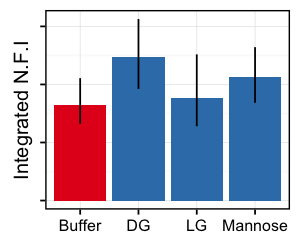

In [57]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated <- ggplot(data = filter(bychannel_recap, channel == 'right') , 
                     aes(x=Substrate, y= smooth)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = lo,ymax = hi ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

# ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
#                       ann.x = c(1, 1,1,0.75), 
#                        ann.xend = c(2,2,2,1.25), 
#                         ann.y = c(1.9, 2.1, 2.3, 0.0037),
#                       ann.yend = c(1.9,2.1,2.3,0.0037), 
#                        ann.text = c("***","*","*",""),
#                        ann.ytextoffset = c (0.04,0.04,0.04,0.04),
#                        ann.xtextoffset = c (.5,0,-0.5,0),
#                       ann.alpha = c(1,1,1,0))

# # ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# # ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
# #order is DG l,c,r LG l,c,r
# ann.data$x.offset <- c(0,1,2,3)
# ann.data$y.offset <- c(0,0,0,0)

# prongsize1 = 0.1
# textoff = 0.3

# integrated <- integrated + 
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
#     geom_segment(data = ann.data,size = 0.3,
#                  aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
#     geom_text(data = ann.data, size= 3.5,
#               aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
#     scale_alpha(guide = 'none')

                
print(integrated)

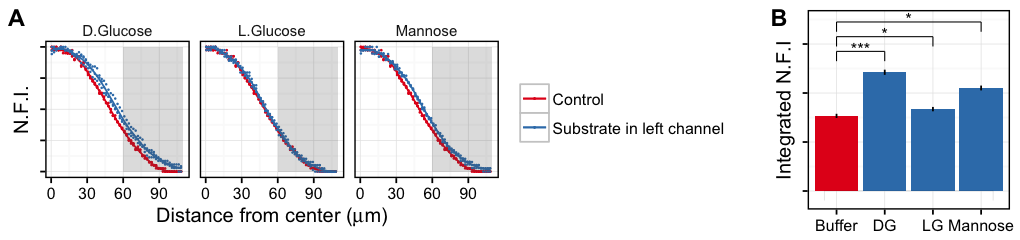

In [68]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1))

### New Figure 5, rev 2 (simplify)

In [59]:
fig5 <- read.csv("../rawdata/fig5.csv")

In [60]:
fig5 <- gather(fig5,"Experiment","Concentration",Buffer:Mannose)

In [61]:
 normalit<-function(m){
   (m - min(m))/sum(m-min(m))
 }

In [62]:
fig5 %<>% group_by(Replicate,Experiment) %>% mutate(Concentration = normalit(Concentration))

In [63]:
head(fig5)

,Distance,Replicate,Experiment,Concentration
1,0,A,Buffer,0
2,1.8884,A,Buffer,0
3,3.7768,A,Buffer,0
4,5.6652,A,Buffer,0
5,7.5535,A,Buffer,0
6,9.4419,A,Buffer,0


In [64]:
fig5$channel <- 0
fig5$channel[fig5$Distance <= 100] <- 'left'
fig5$channel[fig5$Distance > 100 & fig5$Distance <= 220] <- 'center'
fig5$channel[fig5$Distance > 220] <- 'right'
fig5$channel <- factor(fig5$channel, levels = c ('left','center','right'))

In [65]:
fig5_recap <- fig5 %>% group_by(Experiment,channel) %>% summarise(TotalConc= sum(Concentration),
                                                                  ConcSem = qt(0.975,df=2)*sd(Concentration)/sqrt(3))

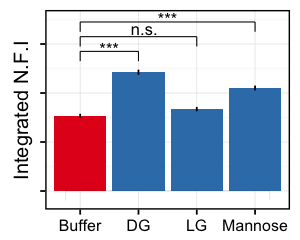

In [84]:
options(repr.plot.width = 2.5, repr.plot.height = 2)
integrated <- ggplot(data = filter(fig5_recap, channel == 'right') , 
                     aes(x=Experiment, y= TotalConc)) + 
    geom_bar(stat = "identity",aes(fill = c(cols[2],cols[1],cols[1],cols[1]))) +
    ylab("Integrated N.F.I") +
scale_fill_brewer(palette='Set1',guide = 'none') +
    theme_bw() +
    theme(panel.border = element_rect(size = .8, colour = "black"),
         axis.text.y = element_text(size=0),
#            axis.text.x = element_text(size = 8),
            axis.title.x = element_blank(),
         legend.title=element_blank(),
        panel.grid.major = element_line())   +
#     annotate("rect", xmin = 0.5, xmax = 4.5, ymin = 0, ymax = +2.555, alpha = .2) +
#     annotate("rect", xmin = 2.5, xmax = 3.5, ymin = 0, ymax = +.0055, alpha = .2) + 
#     geom_bar(stat = "identity",position = "dodge") +
    geom_errorbar(aes(ymin = TotalConc-ConcSem,ymax =  TotalConc+ConcSem ),position = position_dodge(1), width = 0) +
    scale_x_discrete(labels=c("Buffer", "DG", "LG","Mannose"))
#     facet_grid(channel ~ .)
# ,labeller = labeller(Substrate =c(D.Glucose = 'D-Glucose',L.Glucose = 'L-Glucose', Mannose = 'Mannose')))

# data frame for annotation bar

ann.data <- data.frame(Substrate = c("Buffer","D.Glucose","L.Glucose","Mannose"),
                      ann.x = c(1, 1,1,0.75), 
                       ann.xend = c(2,2,2,1.25), 
                        ann.y = .15*c(1.9, 2.1, 2.3, 0.0037),
                      ann.yend = .15*c(1.9,2.1,2.3,0.0037), 
                       ann.text = c("***","n.s.","***",""),
                       ann.ytextoffset = .15*c (0.04,0.11,0.04,0.04),
                       ann.xtextoffset = c (.5,0.1,-0.5,0),
                      ann.alpha = c(1,1,1,0))

# ann.data <- ann.data[rep(seq_len(nrow(ann.data)), each = 3),]
# ann.data$channel <- factor(c('left','center','right','left','center','right'), levels = c ('left','center','right'))
#order is DG l,c,r LG l,c,r
ann.data$x.offset <- c(0,1,2,3)
ann.data$y.offset <- c(0,0,0,0)

prongsize1 = 0.02
textoff = 10

integrated <- integrated + 
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0, y=ann.y+y.offset, xend=ann.xend+x.offset, yend=ann.yend+y.offset, alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.x+x.offset*0,xend=ann.x+x.offset*0,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_segment(data = ann.data,size = 0.3,
                 aes(x = ann.xend+x.offset,xend=ann.xend+x.offset,y=ann.y-prongsize1+y.offset,yend=ann.y+y.offset,alpha = ann.alpha)) +
    geom_text(data = ann.data, size= 3.5,
              aes(x = ann.x+ann.xtextoffset+x.offset, y = ann.y+ann.ytextoffset+y.offset,label = ann.text)) +
    scale_alpha(guide = 'none')

                
print(integrated)

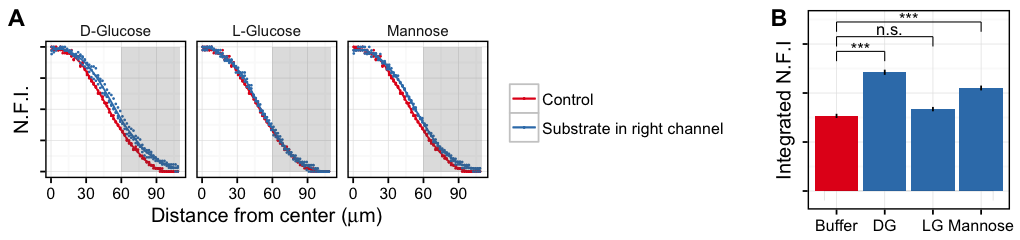

In [90]:
options(repr.plot.width = 8.5, repr.plot.height = 2)

plot_grid(raw,integrated, labels = c("A","B"),ncol = 2,rel_widths = c(2.96,1))

In [91]:
ggsave("../img/RoleOfCatalysisPlotv2.png",width = 8.5, height = 2)